## Imports

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from gurobipy import Model, GRB
from networkx.algorithms.approximation import maxcut

In [5]:
FIGURE_WIDTH_1COL = 3.404  
FIGURE_WIDTH_2COL = 7.057 
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))
plt.rcdefaults()
font_size = 6 
plt.rcParams.update({
    'font.size'             : font_size,
    'font.family'           :'sans-serif',
    # 'figure.facecolor'        : '0.9',
    'figure.titlesize'      : 'medium',
    'figure.dpi'            : 300,
    'figure.figsize'        : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'        : 'medium',
    'axes.axisbelow'        : True,
    'xtick.direction'       : 'in',
    'xtick.labelsize'       : 'small',
    'ytick.direction'       : 'in',
    'ytick.labelsize'       : 'small',
    'image.interpolation'   : 'none',
    'legend.fontsize'       : font_size,
    'axes.labelsize'        : font_size,
    'axes.titlesize'        : font_size,
    'xtick.labelsize'       : font_size,
    'ytick.labelsize'       : font_size,
})

## Helper functions

### Convert partition result to binary

In [33]:
def partition_to_bin(partition):
    """
    This function converts a max cut partition of a graph into a binary number.

    Parameters
    ----------
    partition : tuple
        A tuple containing two sets of nodes that represent the partition of a graph.

    Returns
    -------
    binary_string : str
        A binary number that represents the partition of the graph.
    """
    # Define the subsets
    subset_zero = partition[0]
    subset_one = partition[1]

    # Determine the maximum index to define the size of the binary number
    max_index = max(max(subset_zero), max(subset_one))  # Find the highest index

    # Initialize the binary number list with zeros
    binary_number = [0] * (max_index + 1)

    # Set the positions in the binary number according to the subsets
    for index in subset_one:
        binary_number[index] = 1

    # Since the binary number needs to be expressed as an actual number, convert list to string and then to a binary number
    binary_string = ''.join(str(bit) for bit in binary_number)

    # Print results
    # print("Max cut solution, classical:", binary_string)
    return binary_string

def bin_to_partition(binary_string):
    """
    This function converts a binary number into a max cut partition of a graph.

    Parameters
    ----------
    binary_string : str
        A binary number that represents the partition of the graph.

    Returns
    -------
    partition : tuple
        A tuple containing two sets of nodes that represent the partition of a graph.
    """
    # Convert the binary number to a list of integers
    binary_list = [int(bit) for bit in binary_string]

    # Define the subsets
    subset_zero = set()
    subset_one = set()

    # Set the positions in the subsets according to the binary number
    for index, bit in enumerate(binary_list):
        if bit == 0:
            subset_zero.add(index)
        else:
            subset_one.add(index)

    # Define the partition
    partition = (subset_zero, subset_one)

    # Print results
    # print("Max cut solution, quantum:", partition)
    return partition

In [35]:
G = nx.gnp_random_graph(10, 0.5, seed=42)
print(G)
cut_value, partition = maxcut.one_exchange(G, seed=42)
print(partition)
bin_part = partition_to_bin(partition)
print(bin_part)
part_test = bin_to_partition(bin_part)
print(part_test)

Graph with 10 nodes and 21 edges
({9, 2, 3}, {0, 1, 4, 5, 6, 7, 8})
1100111110
({9, 2, 3}, {0, 1, 4, 5, 6, 7, 8})


### Plot graph with cut

In [10]:
def visualize_max_cut(G, partition, title):
    """
    Visualize the graph with the max cut highlighted

    Parameters
    ----------
    G : networkx.Graph
        The input graph
    partition : tuple
        A partition of the nodes of G into two sets
    title : str
        The title of the plot

    Returns
    -------
    None
    """
    # Prepare to plot the graph
    pos = nx.spring_layout(G)  # positions for all nodes using the spring layout

    # Draw nodes in partition 0
    nx.draw_networkx_nodes(G, pos, nodelist=partition[0], node_color='darkred', node_size=500, alpha=0.8)

    # Draw nodes in partition 1
    nx.draw_networkx_nodes(G, pos, nodelist=partition[1], node_color='darkblue', node_size=500, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Draw node labels
    nx.draw_networkx_labels(G, pos)

    # Set plot title
    fig, ax = plt.subplots()
    # plt.title(title)
    ax.axis('off')  # Turn off the axis
    plt.show()

In [22]:
def max_cut_gurobi(graph):
    model = Model("max_cut")
    model.setParam('OutputFlag', 0)

    # Variables: x[i] is 1 if node i is in one set of the cut, 0 otherwise
    x = model.addVars(graph.nodes(), vtype=GRB.BINARY, name="x")

    # Objective: Maximize the sum of edges between the sets
    model.setObjective(sum(x[i] + x[j] - 2 * x[i] * x[j] for i, j in graph.edges()), GRB.MAXIMIZE)

    # Optimize model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        group1 = {i for i in graph.nodes() if x[i].X >= 0.5}
        group2 = {i for i in graph.nodes() if x[i].X < 0.5}
        return int(model.objVal), [group1, group2]
    else:
        print("No optimal solution found.")
        return None

## Cut visualization

7
[{0, 4, 5}, {1, 2, 3}]


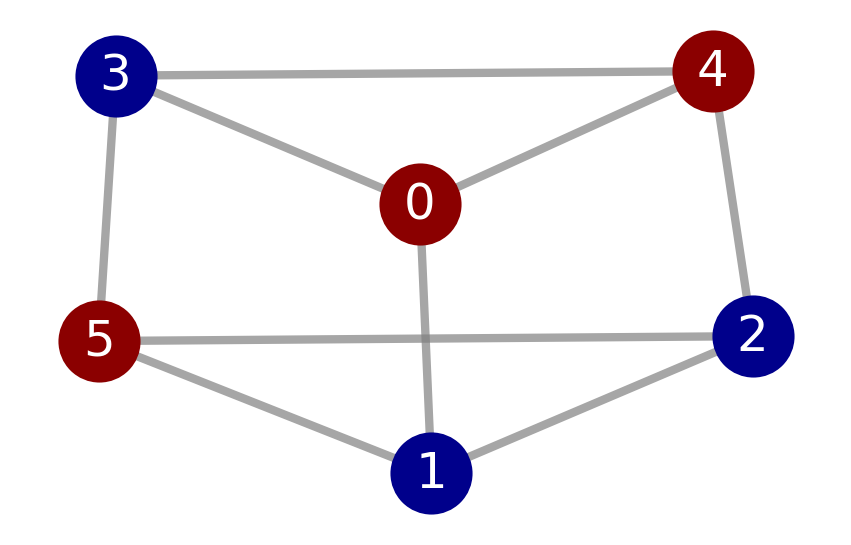

In [24]:
G = G = nx.random_regular_graph(3, 6, seed=42)

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = max_cut_gurobi(G)
print(cut_value)
print(partition)

# Visualize the Max Cut solution
# Prepare to plot the graph
pos = nx.spring_layout(G)  # positions for all nodes using the spring layout

# Create a plot without borders
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis

# Draw nodes in partition 0
nx.draw_networkx_nodes(G, pos, nodelist=partition[0], node_color='darkred', node_size=350, alpha=1, edgecolors='darkred')

# Draw nodes in partition 1
nx.draw_networkx_nodes(G, pos, nodelist=partition[1], node_color='darkblue', node_size=350, alpha=1, edgecolors='darkblue')

# Draw edges
nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.7, edge_color='grey')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_color='white', font_size=12)

# Set plot title
# plt.title(title)
plt.show()


# Graph list

[(0, 7), (0, 3), (0, 6), (7, 6), (7, 8), (3, 4), (3, 1), (4, 9), (4, 8), (1, 5), (1, 9), (5, 9), (5, 2), (6, 2), (2, 8)]


## Pipeline test

In [40]:
def max_cut_gurobi(graph):
    model = Model("max_cut")
    model.setParam('OutputFlag', 0)

    # Variables: x[i] is 1 if node i is in one set of the cut, 0 otherwise
    x = model.addVars(graph.nodes(), vtype=GRB.BINARY, name="x")

    # Objective: Maximize the sum of edges between the sets
    model.setObjective(sum(x[i] + x[j] - 2 * x[i] * x[j] for i, j in graph.edges()), GRB.MAXIMIZE)

    # Optimize model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        print('Max-Cut Value:', int(model.objVal))
        group1 = {i for i in graph.nodes() if x[i].X >= 0.5}
        group2 = {i for i in graph.nodes() if x[i].X < 0.5}
        return [group1, group2]
    else:
        print("No optimal solution found.")
        return None
    
def cost_function_qaoa(results, edges):
    """
    This function calculates the cost of a max cut solution.

    Parameters
    ----------
    results : list
        A list of results from a quantum algorithm.
    edges : list
        A list of edges in the graph.

    Returns
    -------
    cost : int
        The cost of the max cut solution.
    """
    x_vec = results[0][0]
    cost = 0
    for edge in edges:
        n1, n2 = edge
        print(edge)
        cost += int(x_vec[n1])(1-int(x_vec[n2])) + int(x_vec[n2])(1-int(x_vec[n1]))
    return cost

#########################################################################################
CLASSICAL MAX CUT
Approximate Max Cut value: 12
Partition basic: ({0, 1, 4, 5, 6, 8}, {9, 2, 3, 7})
Binary: 0011000101
Start Gurobi Max Cut
Max-Cut Value: 13
Partition Gurobi: [{0, 1, 2, 4, 7}, {3, 5, 6, 8, 9}]


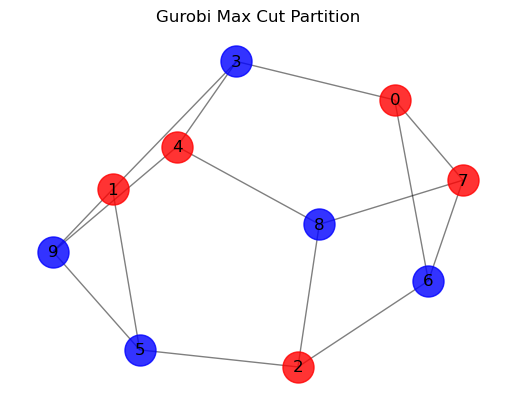

#########################################################################################
<class 'networkx.classes.reportviews.EdgeView'>


TypeError: cannot unpack non-iterable int object

In [44]:
def pipeline(nodes, seed, layer_count, shots_count):
    """
    This function runs the pipeline for the Max Cut problem using QAOA.

    Parameters
    ----------
    nodes : int
        The number of nodes in the graph.
    seed : int
        The seed for the random number generator.
    layer_count : int
        The number of layers in the QAOA ansatz.
    shots_count : int
        The number of shots for the quantum circuit.

    Returns
    -------
    None
    """
    G = nx.random_regular_graph(3, nodes, seed=seed)
    edges = G.edges()

    # Use the greedy approximation algorithm for Max Cut
    cut_value, partition_basic = maxcut.one_exchange(G, seed=seed)
    print('#########################################################################################')
    print('CLASSICAL MAX CUT')
    print("Approximate Max Cut value:", cut_value)
    print("Partition basic:", partition_basic)
    print("Binary:", partition_to_bin(partition_basic))
    print("Start Gurobi Max Cut")
    partition_gurobi = max_cut_gurobi(G)
    print("Partition Gurobi:", partition_gurobi)
    visualize_max_cut(G, partition_gurobi, title="Gurobi Max Cut Partition")
    print('#########################################################################################')

    edges_1 = [edge[0] for edge in edges]
    edges_2 = [edge[1] for edge in edges]
    
    # hamiltonian = get_hamiltonian(edges)

    # # Problem parameters
    # qubit_count: int = hamiltonian.get_qubit_count()
    # layer_count: int = layer_count
    # parameter_count: int = 2 * layer_count
    # shots_count: int = shots_count

    # @cudaq.kernel
    # def kernel_qaoa(edges_src: List[int], edges_tgt: List[int], qubit_count: int, layer_count: int, thetas: List[float]):
    #     """
    #     QAOA ansatz for Max-Cut
        
    #     Parameters
    #     ----------
    #     edges : List[Tuple[int, int]]
    #         The edges of the graph.
    #     qubit_count : int  
    #         The number of qubits.
    #     layer_count : int
    #         The number of layers in the QAOA ansatz.
    #     thetas : List[float]
    #         The angles for the QAOA ansatz.
    #     """
    #     qvector = cudaq.qvector(qubit_count)

    #     # Create superposition
    #     h(qvector)

    #     # Loop over the layers
    #     for layer in range(layer_count):
    #         for i, u in enumerate(edges_src):
    #             v = edges_tgt[i]
    #             x.ctrl(qvector[u], qvector[v])
    #             rz(2.0 * thetas[layer], qvector[v])
    #             x.ctrl(qvector[u], qvector[v])

    #         # Mixer unitary
    #         for qubit in range(qubit_count):
    #             rx(2.0 * thetas[layer + layer_count], qvector[qubit])

    # print("Print circuit of single QAOA layer")
    # print(cudaq.draw(kernel_qaoa, edges_1, edges_2, qubit_count, 1, [1,1]))

    # # Make it repeatable with fixing random seeds
    # cudaq.set_random_seed(13)
    # np.random.seed(13)

    # # Specify the optimizer and its initial parameters for the angles in the layers
    # optimizer = cudaq.optimizers.COBYLA()
    # optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, parameter_count)
    # print("Initial QAOA parameters = ", optimizer.initial_parameters)

    # def objective(parameters):
    #     """
    #     Compute the expected value of the hamiltonian with respect to the kernel.

    #     Parameters
    #     ----------
    #     parameters : List[float]
    #         The parameters to optimize. Contains the angles for the qaoa ansatz.

    #     Returns
    #     -------
    #     result : float
    #         The expectation value of the hamiltonian: `<state(params) | H | state(params)>`
    #     """
    #     return cudaq.observe(kernel_qaoa, hamiltonian, edges_1, edges_2, qubit_count, layer_count, parameters).expectation()

    # optimal_expectation, optimal_parameters = optimizer.optimize(
    #     dimensions=parameter_count, function=objective)

    # # Print the optimized value and its parameters
    # print("Optimal expectation value = ", optimal_expectation)
    # print("Optimal parameters = ", optimal_parameters)

    # # Sample the circuit using the optimized parameters
    # counts = cudaq.sample(kernel_qaoa, edges_1, edges_2, qubit_count, layer_count, optimal_parameters, shots_count=1000000)
    # results = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    # for key, value in results[:10]:
    #     print(f"{key}: {value}")

    # partition_qaoa = bin_to_partition(bin_to_partition(results[0][0]))
    # print("Partition QAOA:", partition_qaoa)
    # visualize_max_cut(G, partition_qaoa, title="QAOA Max Cut Partition")

    # print("Cost function QAOA:", cost_function_qaoa(results, edges))

pipeline(10, 42, 2, 1000)

## Small test graph website

Approximate Max Cut value: 4
Max cut solution, classical: 0101
Partition of nodes: None


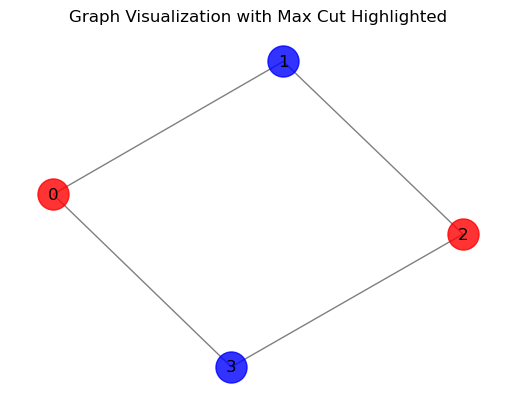

In [42]:
G = nx.Graph()
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]
G.add_edges_from(edges)

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)

# Print results
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition_to_bin(partition))

visualize_max_cut(G, partition)

## Small hex test graph
https://arxiv.org/pdf/2306.09198

Approximate Max Cut value: 8
Partition of nodes: ({0, 2, 5}, {1, 3, 4})
Max cut solution, classical: 010110
Partition of nodes (binary): None


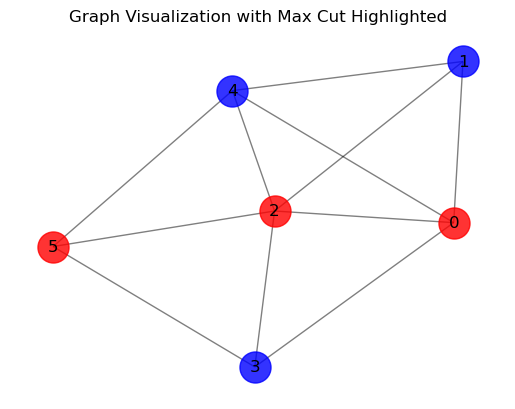

In [100]:
G = nx.Graph()
edges = [(0,1), (0,2), (0,3), (0,4), (1,2), (1,4), (2,3), (2,4), (2,5), (3,5), (4,5)]
G.add_edges_from(edges)

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)

# Print results
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition)
print("Partition of nodes (binary):", partition_to_bin(partition))

visualize_max_cut(G, partition)

## G-10 Create a graph with 10 vertices

Graph with 10 nodes and 21 edges
[(0, 2), (0, 3), (0, 4), (0, 8), (0, 9), (1, 2), (1, 3), (1, 5), (1, 6), (1, 9), (2, 5), (2, 8), (2, 9), (3, 5), (3, 6), (3, 7), (4, 9), (6, 9), (7, 8), (7, 9), (8, 9)]
Approximate Max Cut value: 15
Partition of nodes: ({9, 2, 3}, {0, 1, 4, 5, 6, 7, 8})


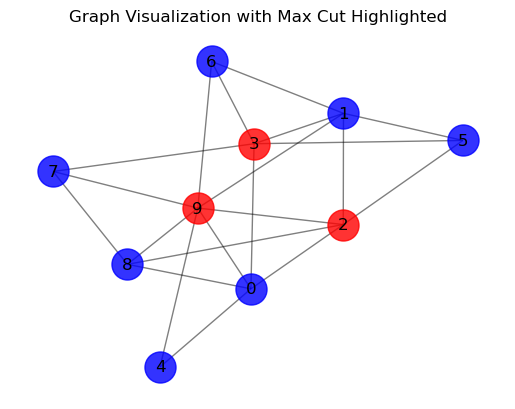

In [75]:
# Create a small random graph
G = nx.gnp_random_graph(10, 0.5, seed=42)
print(G)
print(G.edges)

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition)

visualize_max_cut(G, partition)

## G-20 Create a graph with 20 vertices

Graph with 20 nodes and 98 edges
[(0, 2), (0, 3), (0, 4), (0, 8), (0, 9), (0, 10), (0, 11), (0, 13), (0, 14), (0, 17), (1, 2), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 17), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 15), (2, 16), (2, 17), (2, 18), (3, 6), (3, 8), (3, 9), (3, 16), (3, 17), (3, 18), (3, 19), (4, 5), (4, 8), (4, 10), (4, 12), (4, 13), (4, 14), (4, 16), (4, 19), (5, 6), (5, 9), (5, 10), (5, 11), (5, 14), (5, 15), (5, 16), (6, 8), (6, 12), (6, 14), (6, 15), (6, 16), (6, 19), (7, 9), (7, 12), (7, 15), (8, 9), (8, 10), (8, 11), (8, 15), (8, 16), (8, 19), (9, 10), (9, 11), (9, 14), (9, 15), (9, 17), (9, 19), (10, 11), (10, 14), (10, 15), (10, 18), (11, 12), (11, 13), (11, 14), (11, 16), (11, 17), (11, 18), (12, 13), (12, 16), (12, 17), (12, 19), (13, 14), (13, 17), (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (15, 19), (16, 17), (16, 18), (17, 18), (17, 19), (18, 19)]
Approximate Max Cut value: 63
Partition of nodes: ({17, 2, 3, 5, 8, 10, 12, 14},

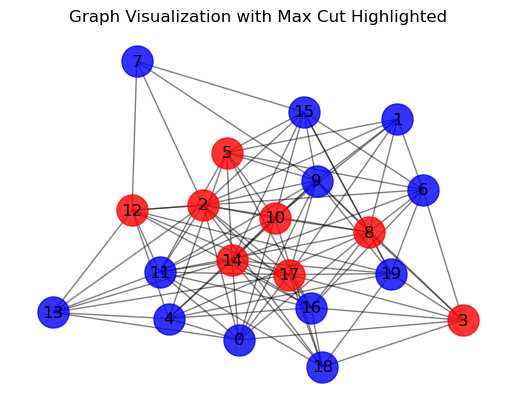

In [48]:
# Create a small random graph
G = nx.gnp_random_graph(20, 0.5, seed=42)
print(G)
print(G.edges)

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)

# Print results
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition)

visualize_max_cut(G, partition)

## G-10-3 3-regular graph with 10 vertices

Graph with 18 nodes and 27 edges
[(6, 12), (6, 4), (6, 1), (12, 17), (12, 2), (4, 2), (4, 10), (5, 7), (5, 16), (5, 3), (7, 13), (7, 9), (16, 9), (16, 15), (1, 11), (1, 8), (11, 14), (11, 0), (14, 13), (14, 8), (0, 3), (0, 9), (10, 15), (10, 17), (15, 13), (2, 3), (8, 17)]
Approximate Max Cut value: 23
Partition of nodes: ({2, 5, 6, 8, 9, 11, 13, 15, 17}, {0, 1, 3, 4, 7, 10, 12, 14, 16})
110110010010101010


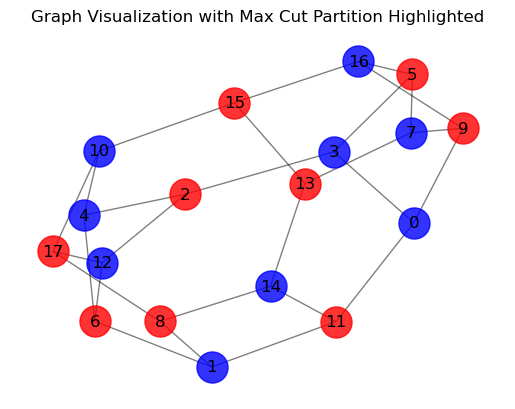

In [32]:
G = nx.random_regular_graph(3, 18, seed=42)
print(G)
print(G.edges())

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition)
print(partition_to_bin(partition))

visualize_max_cut(G, partition)

## G-20-3 3-regular graph with 20 vertices

Graph with 20 nodes and 30 edges
[(6, 18), (6, 17), (6, 19), (18, 13), (18, 0), (4, 15), (4, 8), (4, 2), (15, 10), (15, 16), (5, 16), (5, 19), (5, 11), (16, 10), (19, 17), (11, 14), (11, 12), (14, 8), (14, 1), (10, 2), (13, 17), (13, 7), (7, 9), (7, 1), (8, 3), (3, 12), (3, 2), (12, 9), (0, 1), (0, 9)]
Approximate Max Cut value: 25
Partition of nodes: ({0, 3, 4, 5, 6, 9, 10, 13, 14}, {1, 2, 7, 8, 11, 12, 15, 16, 17, 18, 19})


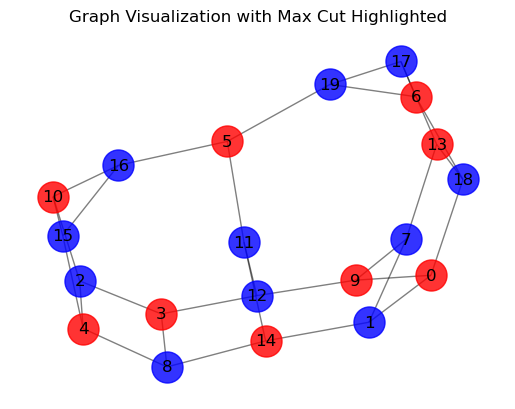

In [69]:
G = nx.random_regular_graph(3, 20, seed=42)
print(G)
print(G.edges())

# Use the greedy approximation algorithm for Max Cut
cut_value, partition = maxcut.one_exchange(G, seed=42)
print("Approximate Max Cut value:", cut_value)
print("Partition of nodes:", partition)

visualize_max_cut(G, partition)